In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the data from CSV files
atom_df = pd.read_csv('data/atom.csv')
whatsapp_df = pd.read_csv('data/whatsapp.csv')
codedx_df = pd.read_csv('data/codedx.csv')

In [13]:
# Concatenate the dataframes
df = pd.concat([atom_df, whatsapp_df, codedx_df], ignore_index=True)

# Drop 'Unnamed column'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop the 'Description' column
df.drop(columns=['Description'], inplace=True)

# Handle missing values for categorical features with a new category 'missing'
categorical_features = ['Severity', 'Tool Category', 'Tool Name', 'Rule Name']
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Handle missing values for numerical feature (CWE) with median
numerical_imputer = SimpleImputer(strategy='median')
df['CWE'] = numerical_imputer.fit_transform(df[['CWE']])

In [14]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns= df.select_dtypes(include=['object']).columns.difference(['Description','Status']))

In [15]:
X = df.drop(columns=['Status'])
y = df['Status']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [16]:
# Model training and evaluation

# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
print("Decision Tree Classifier Results:")
print(classification_report(y_test, dt_predictions))

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print("Random Forest Classifier Results:")
print(classification_report(y_test, rf_predictions))

Decision Tree Classifier Results:
                precision    recall  f1-score   support

     escalated       0.96      0.95      0.96       801
false-positive       0.90      0.92      0.91       399

      accuracy                           0.94      1200
     macro avg       0.93      0.94      0.93      1200
  weighted avg       0.94      0.94      0.94      1200

Random Forest Classifier Results:
                precision    recall  f1-score   support

     escalated       0.96      0.95      0.96       801
false-positive       0.90      0.93      0.91       399

      accuracy                           0.94      1200
     macro avg       0.93      0.94      0.94      1200
  weighted avg       0.94      0.94      0.94      1200



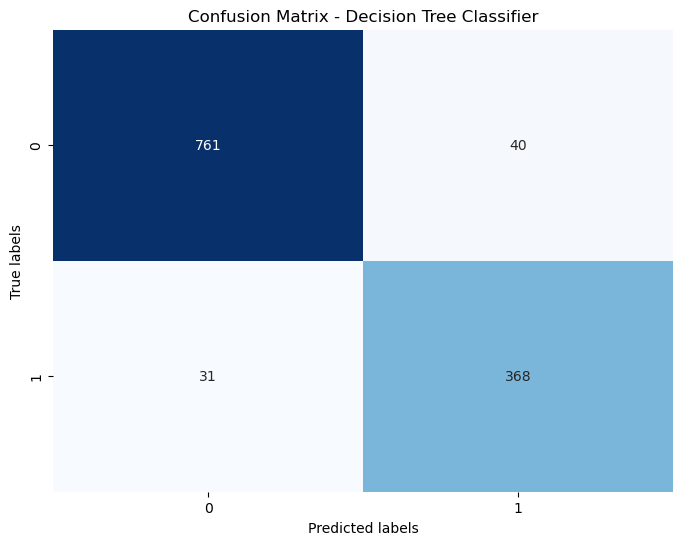

In [17]:
# Confusion matrix for Decision Tree
dt_conf_matrix = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

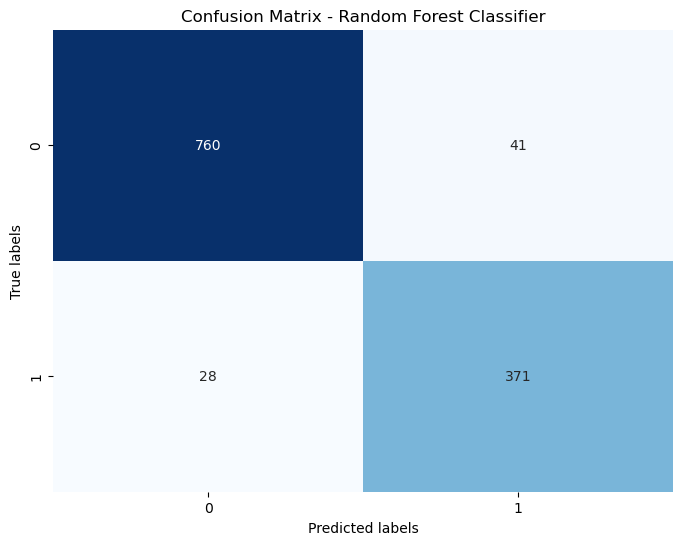

In [18]:
# Confusion matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()